This notebook follows "MinimizingChiSq" and sets up some of the basic ingredients of an MCMC algorithm.  (However, this is *not* the implementation you should use in real life, for reasons that will become clear.)

We start by loading the same dataset as before, and reminding ourselves what the data and $\chi^2$ parameter space look like.

<Container object of 3 artists>

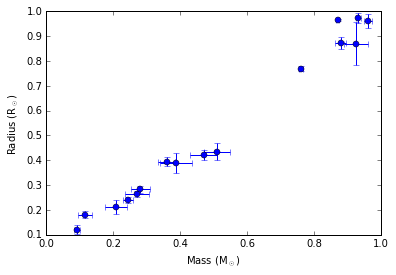

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('Lopez-Morales07_table1.txt', comments=';', delimiter=',')
Mstar = data[:,0]
Merr = data[:,1]
Rstar = data[:,2]
Rerr = data[:,3]

plt.xlabel('Mass (M$_\odot$)')
plt.ylabel('Radius (R$_\odot$)')
plt.errorbar(Mstar, Rstar, xerr=Merr, yerr=Rerr, fmt='o')

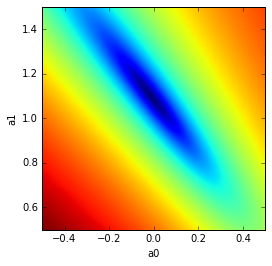

In [27]:
def chi2(A0, A1, X, D, SIGX, SIGD): 
    ''' Calculates chi^2 between the data (X, D) and the line described by y = A0 + A1*x
    
        Input
        =====
        A0 : y-intercept of the model
        A1 : slope of the model
        X : array of x-values from the data
        D : array of y-values from the data
        SIGX : the expected variance of the x-values
            (could be a single value, or an array of the same length as X and D)
        SIGD : the expected variance of the y-values
            (could be a single value, or an array of the same length as X and D)
    '''

    chi2 = np.sum((A0 + A1*X - D)**2/(SIGD**2+(SIGX*A1)**2))
    
    return chi2 

a0grid = np.linspace(-0.5, 0.5, 100)
a1grid = np.linspace(0.5, 1.5, 100)
chi2grid = np.zeros((100,100))

for i in range(0,100):
    for j in range(0,100):
        chi2grid[i,j] = chi2(a0grid[i],a1grid[j],Mstar,Rstar,Merr,Rerr)
        
plt.imshow(np.flipud(np.log10(chi2grid).T), extent=[-0.5, 0.5, 0.5, 1.5])
plt.xlabel('a0')
plt.ylabel('a1')

**Exercise 1**

We could use our time much more efficiently if we didn't have to sample that entire grid of $a_0$ and $a_1$.  This is especially true in more complicated cases where the model has more than two parameters, since the volume of "parameter space" scales exponentially!  

Let's implement a Markov Chain Monte Carlo algorithm that will always move in the direction of increasing likelihood.  Starting at an arbitrary point ($a_0$, $a_1$), the basic steps in the algorithm are as follows:

1) Choose small steps $\Delta a_0$ and $\Delta a_1$ by which to update your position in parameter space.

2) Evaluate the likelihoods at the current position $(a_0, a_1)$ and at the new position $(a_0+\Delta a_0, a_1 + \Delta a_1)$.

3) Compare the two likelihoods.  If the likelihood is higher at the new position, move there!  If not, stay put.

4) Return to step 1.

Let's start with step 1.  A good way to choose $\Delta a_0$ and $\Delta a_1$ is by drawing from a normal distribution centered around 0 (so that you have an equal chance of drawing a positive or negative change).  It can be tricky to select the best value of $\sigma_{\Delta a}$, but for now let's just use 0.1 for both parameters.  You can draw a value from this distribution randomly using np.random.normal() like so:

In [3]:
print(np.random.normal(loc=0.0, scale=0.1))
print(np.random.normal(loc=0.0, scale=0.1))
print(np.random.normal(loc=0.0, scale=0.1))

-0.1326656355550336
-0.10201715752708385
0.10133661261626913


**To do:** Try writing some code that random walks in $(a_0, a_1)$ space, saving the locations as it goes along, and plots the path on top of the $\chi^2$ contours.  A skeleton is below.

Try out different initial locations, step sizes, and total step numbers!

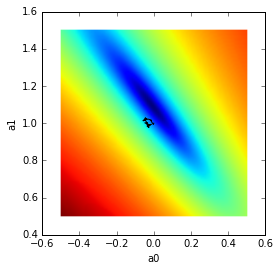

In [36]:
# Initial location
a0 = 0.
a1 = 1.
# Step sizes (sigmas of normal distributions)
da0 = 0.01
da1 = 0.01
# Total number of steps to take
nsteps = 25
# Lists for keeping track of location
a0list = [a0]
a1list = [a1]

for i in range(0,nsteps):
    # YOUR CODE HERE
    # Draw values for delta a0 and delta a1 from a normal distribution
    a0step = np.random.normal(scale=da0)
    a1step = np.random.normal(scale=da1)
    # Update the values of a0 and a1
    a0 += a0step
    a1 += a1step
    
    a0list.append(a0)
    a1list.append(a1)

plt.imshow(np.flipud(np.log10(chi2grid).T), extent=[-0.5, 0.5, 0.5, 1.5])
plt.xlabel('a0')
plt.ylabel('a1')
plt.plot(a0list, a1list, color='black')  

Now let's add in the condition that we will only take a step if it increases the likelihood value.  In this case, it is actually easier to stick with $\chi^2$ rather than evaluating the likelihood itself, because computers don't really like comparing exponentials of large negative numbers.

You can keep the same code from above, but now include an "if" statement before accepting the new step.

As before, mess around with different starting locations, step sizes, and total number of steps.  How do these affect the behavior?  How many steps do you typically need to converge to within 0.01 of the minimum values (-0.0132, 1.1029)?  Within 0.001?

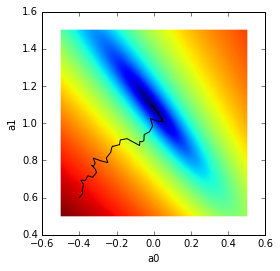

In [39]:
# Initial location
a0 = -0.4
a1 = 0.6
# Step sizes (sigmas of normal distributions)
da0 = 0.02
da1 = 0.02
# Total number of steps to take
nsteps = 1000
# Lists for keeping track of location
a0list = [a0]
a1list = [a1]

for i in range(0,nsteps):
    # YOUR CODE HERE
    # Draw values for delta a0 and delta a1 from a normal distribution
    a0step = np.random.normal(scale=da0)
    a1step = np.random.normal(scale=da1)
    # IF the chi2 value is lower (likelihood is higher) at the new location,
    if chi2(a0 + a0step, a1 + a1step, Mstar, Rstar, Merr, Rerr) < chi2(a0, a1, Mstar, Rstar, Merr, Rerr):
    # Update the values of a0 and a1
        a0 += a0step
        a1 += a1step
    
        a0list.append(a0)
        a1list.append(a1)

plt.imshow(np.flipud(np.log10(chi2grid).T), extent=[-0.5, 0.5, 0.5, 1.5])
plt.xlabel('a0')
plt.ylabel('a1')
plt.plot(a0list, a1list, color='black')  

As you may have deduced, there is a major problem with using this method - what if you have local extrema?  If you wander in, you will get stuck there and will be unable to find the global minimum/maximum.

Tomorrow, we will discuss how to get around this issue and introduce ourselves to the Metropolis-Hastings algorithm!